<a href="https://colab.research.google.com/github/ahjeong1158/LSTM-ETTForecast/blob/main/%EC%B5%9C%EC%95%84%EC%A0%95_%EC%BD%94%EB%94%A9%ED%85%8C%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

**Task**

- 결측치가 존재하는 데이터셋에 대한 시계열 예측 및 평가 분석 진행

**Dataset**

- 기존 벤치마크 데이터셋(ETTh1)에서 인덱스 및 결측치 추가하여 전달
- 결측치 여부는 사전에 공개하지 않음

**Code**

- 기본적인 코드 틀 대신 프레임워크 구성 가능 여부 확인
- 데이터 분석 및 전처리 - 데이터셋 및 로더 구성 - 모델 구축 및 학습 - 성능 평가 및 결과 해석
- 기존 모델 코드 그대로 사용 금지

**Submit**

- 모든 과정에 대한 명확한 근거와 설명 문서화
- 실험 결과의 로깅 및 시각화
- 제출 파일은 README, 주피터 노트북 형태로 개인 repo에 push 한 다음 repo 링크를 제출

**Dataset**
- ETT (Electricity Transformer Temperature) dataset
- ETT-small: The data of 2 Electricity Transformers at 2 stations, including load, oil temperature
-  consists of 8 variables, including the date of the point, the oil temperature and 6 other parameters measured at electric transformer stations in China
- hourly measurements of parameters of the same type
- date: The recorded date
- HUFL: High UseFul Load
- HULL: High UseLess Load
- MUFL: Middle UseFul Load
- MULL: Middle UseLess Load
- LUFL: Low UseFul Load
- LULL: Low UseLess Load
- OT: Oil Temperature (target)

---

## 0. 초기 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/SNU DSBA'

Mounted at /content/drive
/content/drive/MyDrive/SNU DSBA


In [ ]:
# 필요 라이브러리 설치
!pip install omegaconf

In [ ]:
# 기본 라이브리러리
import torch
from torch.utils.data import DataLoader

import numpy as np
import os
import json
import shutil
import logging
import warnings
warnings.filterwarnings("ignore")

from glob import glob

from accelerate import Accelerator, DistributedDataParallelKwargs
from accelerate.logging import get_logger
from accelerate.utils import set_seed

from omegaconf import OmegaConf

################### 추가 라이브러리(이용시) ######################
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset
import torch.nn as nn
from typing import Optional, Tuple
import math
############################################################

In [ ]:
# Training argument
config = {
    "DEFAULT": {
        "exp_name": "forecasting_exchange_rate_96_24_noscale",
        "seed": 42
    },
    "DATASET": {
        "taskname": "long_term_forecast",
        "dataname": "custom",
        "sub_data_name": None,
        "scaler": "standard",
        "window_size": 96,
        "label_len": 0,
        "pred_len": 24, # 변경함
        "model_type": "forecasting",
        "pretrain": False,
        "split_rate": [0.7, 0.1, 0.2],
        "timeenc": 0,
        "freq": "h",
        "embed_type": "learned"
    },
    "DATAINFO": {
        "datadir": "./dataset/ETT-small/ETTh1_adjust.csv",
        "target_col": "OT", # 추가함
        "train_path": "",
        "valid_path": "",
        "test_path": "",
        "test_label_path": ""
    },
    "TRAIN": {
        "epoch": 30,
        "batch_size": 64,
        "test_batch_size": 128,
        "num_workers": 0,
        "ckp_metric": "MSE",
        "eval_epochs": 1,
        "log_epochs": 1,
        "log_eval_iter": 50,
        "shuffle": False,
        "pin_memory": True,
        "resume": False,
        "resume_number": 0,
        "early_stopping_metric": "loss",
        "early_stopping_count": 20,
        "return_output": True,
        "lradj": None, # learning rate scheduler 미적용 (type1/2 실험 시 loss 발산)
        "wandb": {
            "use": False,
            "iter": 50,
            "exp_name": "default",
            "project_name": "TMAE",
            "entity": "jinwoo"
        }
    },
    "LOSS": {
        "loss_name": "MSELoss"
    },
    "OPTIMIZER": {
        "opt_name": "AdamW",
        "lr": 0.001,
        "params": {
            "weight_decay": 0.0005
        }
    },
    "RESULT": {
        "savedir": "./saved_model"
    }
}

# Model arguments
models_config = {
##################### EDIT YOUR CODE #########################
    "MyLSTMModel": {
        "enc_in": 7,
        "hidden_size": 128,
        "num_layers": 2,
    }
##############################################################
}

cfg = OmegaConf.create(config)

##################### EDIT YOUR CODE #########################
cfg = OmegaConf.merge(cfg, {'MODEL':{'modelname' : 'MyLSTMModel'}})
##############################################################

model_cfg = OmegaConf.create(models_config)
modelname = cfg.MODEL.modelname

if modelname in model_cfg:
    model_setting_conf = OmegaConf.create(model_cfg[cfg.MODEL.modelname])
    cfg = OmegaConf.merge(cfg, {'MODELSETTING' : model_setting_conf})
else:
    print(f"Model '{modelname}' not found in the model_config.")

---

In [ ]:
def make_save(accelerator, savedir: str, resume: bool = False) -> str:
    # resume
    if resume:
        assert os.path.isdir(savedir), f'{savedir} does not exist'
        # check version
        version = len([f for f in glob.glob(os.path.join(savedir, '*')) if os.path.isdir(f)])
        # init version
        if version == 0:
            files = [f for f in glob.glob(os.path.join(savedir, '*')) if os.path.isfile(f)]
            version0_dir = os.path.join(savedir, f'train{version}')

            accelerator.wait_for_everyone()
            if accelerator.is_main_process:
                os.makedirs(version0_dir)
                for f in files:
                    shutil.move(f, f.replace(savedir, version0_dir))
            version += 1

        savedir = os.path.join(savedir, f'train{version}')
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        os.makedirs(savedir, exist_ok=True)
    print("make save directory {}".format(savedir))

    return savedir

In [ ]:
_logger = get_logger('train')

# set seed
set_seed(cfg.DEFAULT.seed)

# set accelrator
accelerator = Accelerator()

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
    )

# make save directory
savedir = os.path.join(cfg.RESULT.savedir, cfg.MODEL.modelname, cfg.DEFAULT.exp_name)
savedir = make_save(accelerator = accelerator, savedir=savedir, resume=cfg.TRAIN.resume)

# set device
_logger.info('Device: {}'.format(accelerator.device), main_process_only=False)

make save directory ./saved_model/MyLSTMModel/forecasting_exchange_rate_96_24_noscale


## 1. 데이터 분석 및 전처리

    1-1) 제공된 데이터에 기본적인 분석 진행 (통계량 분석, 결측치 확인, 정상성 분석, 시계열 분해 등)
    1-2) 확인된 특성을 반영하여 전처리 진행 (이상치 처리, 결측치 처리, 정규화 등)
    1-3) 전처리된 데이터를 바탕으로 다시 한번 분석 진행 후 수정된 부분 기술 (통계량 분석, 결측치 확인, 정상성 분석, 시계열 분해 등)
    1-4) 수정 내용을 반영하며, create_dataloader_default에 기술된 argument가 포함될 수 있도록 함수 작성
    1-5) Argument가 기재된 의도를 파악하여 최대한 많은 argument사용하여 작성
    1-6) Pytorch 라이브러리를 통하여 모델링 가능하게끔 데이터셋 구성 및 로더 구성
    1-7) 데이터셋 구성 중, 간격이 달라지는 시점이 존재한다면 해당 부분은 데이터셋으로 구성되지 않도록 구성

---------------------------------------------------------------------------
1-1) 통계량 분석, 결측치 확인, 정상성 분석
---------------------------------------------------------------------------
[통계량 분석]
               HUFL          HULL          MUFL          MULL          LUFL  \
count  14184.000000  14184.000000  14184.000000  14184.000000  14184.000000   
mean       7.424993      2.220812      4.347884      0.859804      3.065229   
std        6.988384      2.036135      6.739794      1.806515      1.157685   
min      -22.705999     -4.756000    -25.087999     -5.934000     -1.188000   
25%        5.894000      0.737000      3.376000     -0.320000      2.315000   
50%        8.774000      2.210000      5.970000      0.924000      2.833000   
75%       11.721000      3.684000      8.599000      2.168000      3.625000   
max       23.643999     10.114000     17.341000      7.747000      8.498000   

               LULL            OT  
count  14184.000000  14184.000000  
mean       0.856498     13.

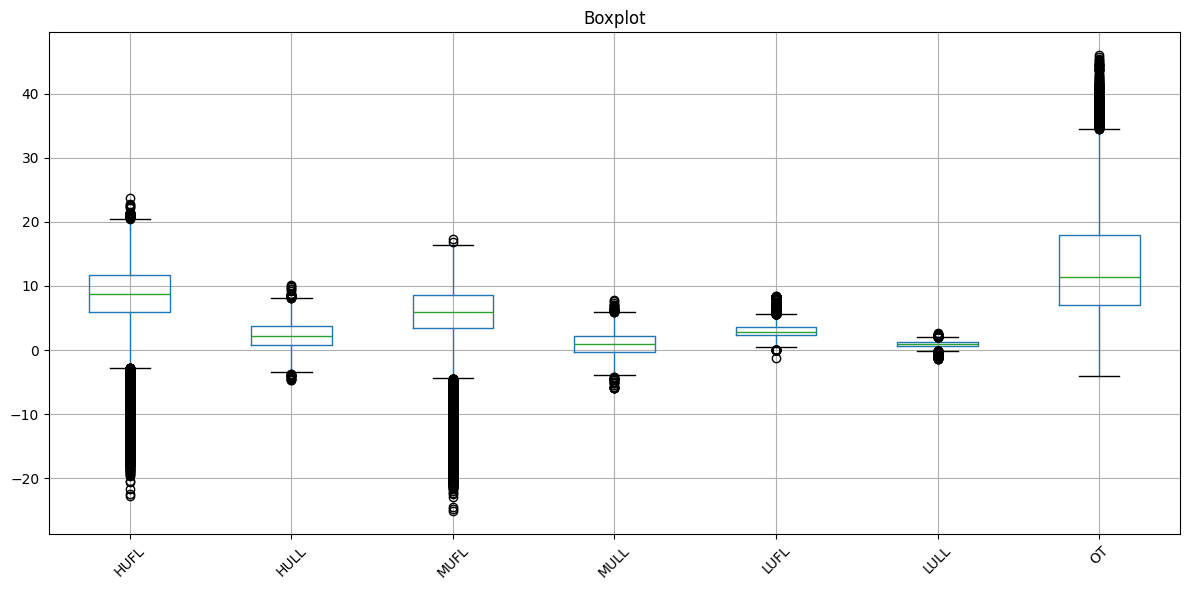


[결측치 확인]
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

[정상성 분석 (ADF 검정)]
ADF Statistic       : -3.6080
p-value             : 0.0056
Used Lag            : 39
N Observations      : 14144
Critical Values(1%) : -3.4308
Critical Values(5%) : -2.8617
Critical Values(10%): -2.5669
IC Best             : 40016.86
→ 정상성 있음
---------------------------------------------------------------------------
1-2) 전처리(결측치 처리, 정규화
---------------------------------------------------------------------------
[결측치 처리]
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

---------------------------------------------------------------------------
1-3) 전처리된 데이터의 통계량 분석, 결측치 확인, 정상성 분석
---------------------------------------------------------------------------
[통계량 분석]
               HUFL          HULL          MUFL          MULL          LUFL  \
count  1.418400e+04  1.418400e+04  1.418400e+04  1.418400e+04  1.418400e+04   
mean  -6.412117e-17  4.

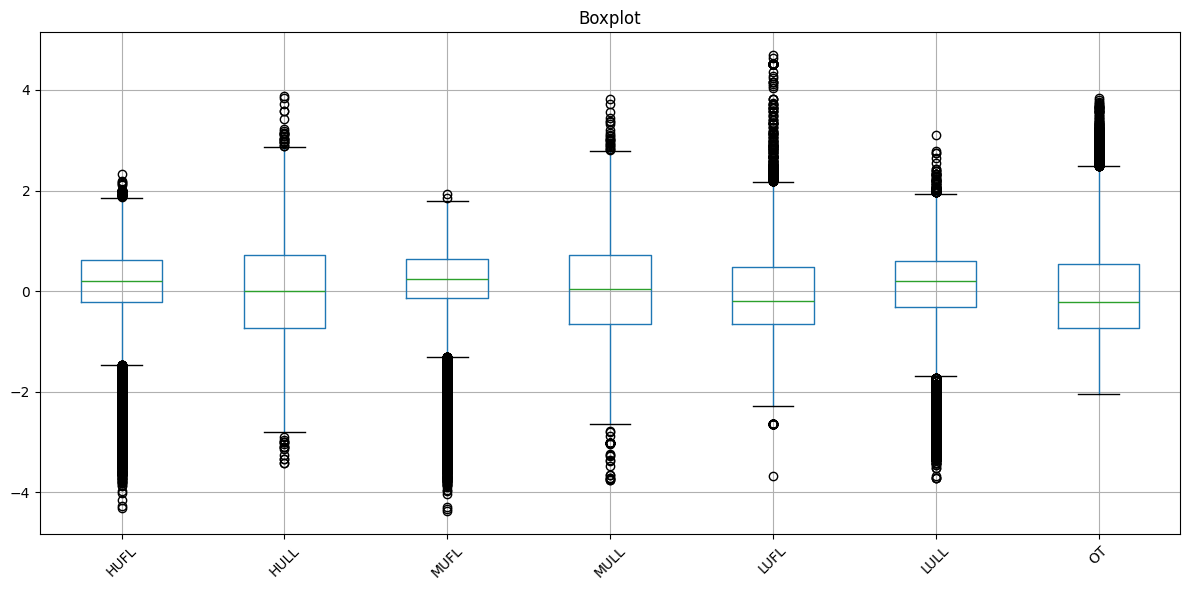


[결측치 확인]
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

[정상성 분석 (ADF 검정)]
ADF Statistic       : -3.6080
p-value             : 0.0056
Used Lag            : 39
N Observations      : 14144
Critical Values(1%) : -3.4308
Critical Values(5%) : -2.8617
Critical Values(10%): -2.5669
IC Best             : -20586.11
→ 정상성 있음


In [ ]:
# 1-1~3 항목의 EDA 코드 작성
################### EDIT YOUR CODE #########################
# 데이터 불러오기
df = pd.read_csv(cfg.DATAINFO.datadir)

# 인덱스 설정
df['date'] = pd.to_datetime(df['date'], errors="coerce")
df = df.set_index('date').sort_index()

target_col = cfg.DATAINFO.target_col
feature_cols = list(df.columns)

# 1-1) 통계량 분석, 결측치 확인, 정상성 분석
print('---------------------------------------------------------------------------')
print('1-1) 통계량 분석, 결측치 확인, 정상성 분석')
print('---------------------------------------------------------------------------')

# 1-1-1) 통계량 분석
print('[통계량 분석]')
# 기술 통계량
print(df.describe())
print()
# box plot
plt.figure(figsize=(12,6))
df.boxplot(column=feature_cols)
plt.title("Boxplot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print()

# 1-1-2) 결측치 확인
print('[결측치 확인]')
print(df.isnull().sum())
print()

# 1-1-3) 정상성 분석
series = df[target_col]
series = series.dropna()
adf_result = adfuller(series)
adf_stat, pval, usedlag, nobs, crit_vals, icbest = adf_result
print('[정상성 분석 (ADF 검정)]')
print(f"ADF Statistic       : {adf_stat:.4f}")
print(f"p-value             : {pval:.4f}")
print(f"Used Lag            : {usedlag}")
print(f"N Observations      : {nobs}")
for k, v in crit_vals.items():
  if k == '10%':
    print(f"Critical Values({k}): {v:.4f}")
  else:
    print(f"Critical Values({k}) : {v:.4f}")
print(f"IC Best             : {icbest:.2f}")
if pval < 0.05:
    print("→ 정상성 있음")
else:
    print("→ 정상성 없음")

# 1-2) 전처리(결측치 처리, 정규화) - 이상치는 제거하지 않음
print('---------------------------------------------------------------------------')
print('1-2) 전처리(결측치 처리, 정규화')
print('---------------------------------------------------------------------------')
df_clean = df.copy()

# 1-2-1) 결측치 처리
print('[결측치 처리]')
df_clean = df_clean.interpolate(method='linear').ffill().bfill()
print(df_clean.isnull().sum())
print()

# 1-2-2) 정규화
df_scaled = df_clean.copy()
scaler = StandardScaler()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

# 1-3) 전처리된 데이터의 통계량 분석, 결측치 확인, 정상성 분석
print('---------------------------------------------------------------------------')
print('1-3) 전처리된 데이터의 통계량 분석, 결측치 확인, 정상성 분석')
print('---------------------------------------------------------------------------')

# 1-3-1) 통계량 분석
print('[통계량 분석]')
# 기술 통계량
print(df_scaled.describe())
print()
# box plot
plt.figure(figsize=(12,6))
df_scaled.boxplot(column=feature_cols)
plt.title("Boxplot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print()

# 1-3-2) 결측치 확인
print('[결측치 확인]')
print(df_scaled.isnull().sum())
print()

# 1-3-3) 정상성 분석
series = df_scaled[target_col]
series = series.dropna()
adf_result = adfuller(series)
adf_stat, pval, usedlag, nobs, crit_vals, icbest = adf_result
print('[정상성 분석 (ADF 검정)]')
print(f"ADF Statistic       : {adf_stat:.4f}")
print(f"p-value             : {pval:.4f}")
print(f"Used Lag            : {usedlag}")
print(f"N Observations      : {nobs}")
for k, v in crit_vals.items():
  if k == '10%':
    print(f"Critical Values({k}): {v:.4f}")
  else:
    print(f"Critical Values({k}) : {v:.4f}")
print(f"IC Best             : {icbest:.2f}")
if pval < 0.05:
    print("→ 정상성 있음")
else:
    print("→ 정상성 없음")
############################################################

In [ ]:
def create_sequences(X, y, window_size, pred_len, index, freq):
      '''
      간격이 달라지는 시점은 데이터셋으로 구성되지 않도록
      '''
      X_list, y_list = [], []
      # freq을 연산 가능하도록 offset 형태로 변환
      off = pd.tseries.frequencies.to_offset(freq)
      # index[i]->index[i+1]이 연속인지 확인 후 is_continue[i+1]에 저장
      is_continue = (index.to_series() == index.to_series().shift(1) + off).to_numpy()

      N = len(X)

      # 1차원 벡터를 열 벡터로 변환
      if y.ndim == 1:
          y = y.reshape(-1, 1)

      for i in range(N - window_size - pred_len + 1):
          j = i + window_size + pred_len - 1 # N
          # 윈도우 내부 모든 간격이 연속이어야 채택
          if not np.all(is_continue[i+1:j+1]):
              continue
          X_list.append(X[i:i+window_size])
          y_list.append(y[i+window_size:j+1])

      X_arr = np.asarray(X_list, dtype=np.float32)
      y_arr = np.asarray(y_list, dtype=np.float32)
      return X_arr, y_arr

def create_dataloader_default(
        task_name: str,
        data_name: str,
        sub_data_name: str,
        data_info: dict,
        train_setting: dict,
        scaler: str,
        window_size: int,
        label_len: int,
        pred_len: int,
        model_type: str,
        split_rate: list,
        timeenc: int,
        freq: str
        ):
    #################### EDIT YOUR CODE #########################
    # 데이터 불러오기
    path = data_info.datadir
    df = pd.read_csv(path)

    # 인덱스 설정
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors="coerce")
        df = df.set_index('date').sort_index()

    # 결측 인덱스가 없도록 reindexing
    start = df.index.min()
    end   = df.index.max()
    full_idx = pd.date_range(start=start, end=end, freq=freq)
    df = df.reindex(full_idx)

    # train/val/test 분리
    n = len(df)
    n_trn = int(n * split_rate[0])
    n_valid = int(n * split_rate[1])

    df_trn = df.iloc[:n_trn].copy()
    df_valid = df.iloc[n_trn:n_trn+n_valid].copy()
    df_test = df.iloc[n_trn+n_valid:].copy()

    # 결측치 보간 - 데이터 누수 방지를 위해 train/val/test 분리 후 보간
    for d in (df_trn, df_valid, df_test):
        d.interpolate(method='linear', inplace=True)
        d.ffill(inplace=True); d.bfill(inplace=True)

    # X, y 분리 - target col도 X에 포함되도록
    target_col = data_info.target_col
    feature_cols = list(df.columns)

    X_trn, y_trn = df_trn[feature_cols].values, df_trn[target_col].values
    X_valid, y_valid = df_valid[feature_cols].values, df_valid[target_col].values
    X_test, y_test = df_test[feature_cols].values, df_test[target_col].values

    # 정규화
    if scaler == 'standard':
      sc_X, sc_y = StandardScaler(), StandardScaler()
    elif scaler == 'minmax':
      sc_X, sc_y = MinMaxScaler(), MinMaxScaler()
    else:
      sc_X, sc_y = None, None

    if sc_X is not None:
      # train 데이터로 fit 해서 val/test에 적용
      X_trn, y_trn = sc_X.fit_transform(X_trn), sc_y.fit_transform(y_trn.reshape(-1, 1))
      X_valid, y_valid = sc_X.transform(X_valid), sc_y.transform(y_valid.reshape(-1, 1))
      X_test, y_test = sc_X.transform(X_test), sc_y.transform(y_test.reshape(-1, 1))

    # 시퀀스 데이터 생성
    X_trn_seq, y_trn_seq = create_sequences(X_trn, y_trn, window_size, pred_len, df_trn.index, freq)
    X_valid_seq, y_valid_seq = create_sequences(X_valid, y_valid, window_size, pred_len, df_valid.index, freq)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size, pred_len, df_test.index, freq)

    # X, y 쌍 결합
    trn_set = TensorDataset(torch.from_numpy(X_trn_seq), torch.from_numpy(y_trn_seq))
    valid_set = TensorDataset(torch.from_numpy(X_valid_seq), torch.from_numpy(y_valid_seq))
    test_set = TensorDataset(torch.from_numpy(X_test_seq), torch.from_numpy(y_test_seq))

    # dataloader 생성
    trn_dataloader = DataLoader(trn_set, batch_size=train_setting.batch_size, shuffle=train_setting.shuffle, num_workers=train_setting.num_workers, pin_memory=train_setting.pin_memory,drop_last=True)
    valid_dataloader = DataLoader(valid_set, batch_size=train_setting.test_batch_size, shuffle=train_setting.shuffle, num_workers=train_setting.num_workers, pin_memory=train_setting.pin_memory,drop_last=False)
    test_dataloader = DataLoader(test_set, batch_size=train_setting.test_batch_size, shuffle=train_setting.shuffle, num_workers=train_setting.num_workers, pin_memory=train_setting.pin_memory,drop_last=False)

    # 정보 반환
    information_dict = {
        "task_name": task_name,
        "data_name": data_name,
        "sub_data_name": sub_data_name,
        "enc_in": X_trn.shape[1],
        "c_out": 1,
        "target_col": target_col
    }

    return information_dict, trn_dataloader, valid_dataloader, test_dataloader, sc_y # return에 sc_y 추가 (inverse_transform을 위해)
    #############################################################

In [ ]:
# load and define dataloader
information_dict, trn_dataloader, valid_dataloader, test_dataloader, sc_y = create_dataloader_default(
            task_name         = cfg.DATASET.taskname, # long_term_forecast
            data_name         = cfg.DATASET.dataname, # custom
            sub_data_name     = cfg.DATASET.sub_data_name, # None
            data_info         = cfg.DATAINFO, # datadir,train_path,valid_path,test_path,test_label_path
            train_setting     = cfg.TRAIN, # epoch,batch_size 등
            scaler            = cfg.DATASET.scaler, # scaler
            window_size       = cfg.DATASET.window_size, # 48
            label_len         = cfg.DATASET.label_len, # 0
            pred_len          = cfg.DATASET.pred_len, # 24
            model_type        = cfg.DATASET.model_type, # forecasting
            split_rate        = cfg.DATASET.split_rate,# [0.7, 0.1, 0.2]
            timeenc           = cfg.DATASET.timeenc, # 0
            freq              = cfg.DATASET.freq # h
            )

In [ ]:
# Update dataset information to cfg

def update_information(model_name, cfg, information_dict):
    dataset_attrs = ['window_size', 'label_len', 'pred_len', 'taskname',
                     'pretrain', 'timeenc', 'freq', 'embed_type']

    for attr in dataset_attrs:
        setattr(cfg.MODELSETTING, attr, getattr(cfg.DATASET, attr))

    cfg.MODELSETTING.batch_size = cfg.TRAIN.batch_size

    model_attrs = ['enc_in', 'c_out']
    for attr in model_attrs:
        if attr in information_dict:
            setattr(cfg.MODELSETTING, attr, information_dict[attr])


update_information(model_name        = cfg.MODEL.modelname,
                    cfg              = cfg,
                    information_dict = information_dict)

## 2. 모델 구축

    2-1) 시계열 예측이 가능한 모델 형태 임의로 구성하여 사용. 기존 모델을 사용하는 경우 재현하여 사용할 것
    2-2) 모델의 입력부터 출력까지 모든 변화 중 모델의 차원 형태 변화 기재

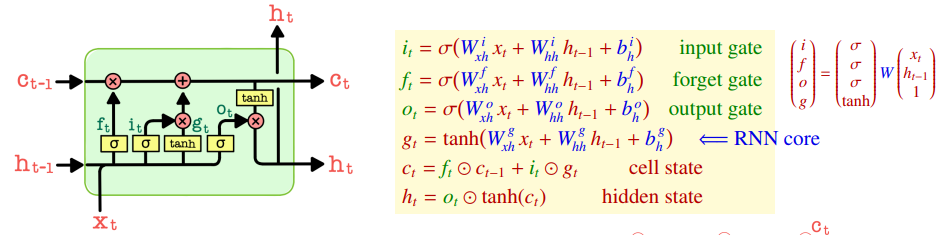

In [ ]:
#################### EDIT YOUR CODE #########################
class MyLSTMCell(nn.Module):
  def __init__(self, input_size: int, hidden_size: int):
      super().__init__()
      self.input_size  = input_size
      self.hidden_size = hidden_size
      # 하나의 선형변환으로 4H 게이트 동시 계산 (bias 포함)
      self.W = nn.Linear(input_size + hidden_size, 4 * hidden_size, bias=True) # W = [4H,D+H]

      # 초기화
      nn.init.xavier_uniform_(self.W.weight)
      nn.init.zeros_(self.W.bias)

      # f gate의 bias는 1로 초기화 (학습 안정성을 위해)
      with torch.no_grad():
        H = hidden_size
        self.W.bias[H:2*H].fill_(1.0)   # [i|f|g|o] 중 f 게이트 구간

  def forward(self, x_t, h_prev, c_prev):
      z = torch.cat([x_t, h_prev], dim=-1) # x_t = [B,D], h_prev = [B,H] → z = [B,D+H]
      gates = self.W(z) # z @ W.T + b → [B,4H]
      i, f, g, o = torch.chunk(gates, 4, dim=-1) # 각각 [B,H]로 분할
      i = torch.sigmoid(i) # [B,H]
      f = torch.sigmoid(f) # [B,H]
      g = torch.tanh(g) # [B,H]
      o = torch.sigmoid(o) # [B,H]

      c_t = f * c_prev + i * g # [B,H]
      h_t = o * torch.tanh(c_t) # [B,H]
      return h_t, c_t

class MyLSTM(nn.Module):
  def __init__(self, params: dict):
      super().__init__()
      input_size  = params.enc_in
      hidden_size = params.hidden_size
      num_layers  = params.num_layers

      self.hidden_size = hidden_size
      self.num_layers  = num_layers

      self.cells = nn.ModuleList(
          [MyLSTMCell(input_size, hidden_size)] +
          [MyLSTMCell(hidden_size, hidden_size) for _ in range(num_layers - 1)]
      )

  def forward(
      self,
      x: torch.Tensor # [B,T,D]
  ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
      x = x.transpose(0, 1)  # [B,T,D] → [T,B,D]
      T, B, _ = x.shape
      device, dtype = x.device, x.dtype

      # 초기화
      h = torch.zeros(self.num_layers, B, self.hidden_size, device=device, dtype=dtype) # [L,B,H]
      c = torch.zeros_like(h)
      h_list, c_list = list(torch.unbind(h, 0)), list(torch.unbind(c, 0)) # [L,B,H] → [B,H] L개 리스트

      outputs = []
      for t in range(T):
          inp = x[t]  # [B,D]
          for l, cell in enumerate(self.cells):
              h_list[l], c_list[l] = cell(inp, h_list[l], c_list[l]) # [B,H]: l번째 레이어 현재 상태
              inp = h_list[l]
          outputs.append(inp)

      out = torch.stack(outputs, 0) # [T,B,H]
      # h_n: 각 layer L의 마지막 시점 hidden state을 모아놓은 tensor
      # c_n: 각 layer L의 마지막 시점 cell state을 모아놓은 tensor
      h_n, c_n = torch.stack(h_list, 0), torch.stack(c_list, 0) # [L,B,H]
      return out, (h_n, c_n)

class MyLSTMModel(nn.Module):
  def __init__(self, params: dict):
      super().__init__()
      self.lstm = MyLSTM(params) # (out,(h_n,c_n)) 반환
      self.hidden_size = params.hidden_size
      self.pred_len = params.pred_len
      self.c_out = params.c_out
      # 마지막 hidden state을 예측 벡터로 사상 (Direct Multistep prediction)
      self.fc = nn.Linear(self.hidden_size, self.pred_len * self.c_out)

  def forward(self, x: torch.Tensor):
      out, (h_n, c_n) = self.lstm(x)
      h_last = h_n[-1] # [B,H] (top layer의 마지막 hidden state)
      y = self.fc(h_last).view(x.size(0), self.pred_len, self.c_out)  # [B,pred_len,c_out]
      return y
############################################################

In [ ]:
def create_model(modelname: str, params: dict):
    model_classes = globals()

    if modelname not in model_classes:
        raise ValueError(f"Model '{modelname}' not found. Make sure the class is defined or imported.")

    model_class = model_classes[modelname]
    if not callable(model_class):
        raise TypeError(f"'{modelname}' is not callable. Ensure it is a valid class or function.")

    return model_class(params)

def create_criterion(loss_name: str, params: dict = {}):
    loss_classes = vars(__import__('torch.nn', fromlist=[''])).get(loss_name)
    return loss_classes(**params)

def create_optimizer(model, opt_name: str, lr: float, params: dict = {}):
    opt_classes = vars(__import__('torch.optim', fromlist=[''])).get(opt_name)
    return opt_classes(model.parameters(), lr=lr, **params)

# build Model
model = create_model(
    modelname    = cfg.MODEL.modelname,
    params       = cfg.MODELSETTING
    )

# set training
criterion = create_criterion(loss_name=cfg.LOSS.loss_name)
optimizer = create_optimizer(model=model, opt_name=cfg.OPTIMIZER.opt_name, lr=cfg.OPTIMIZER.lr, params=cfg.OPTIMIZER.params)

print('# of learnable params: {}'.format(np.sum([p.numel() if p.requires_grad else 0 for p in model.parameters()])))

# of learnable params: 204312


파라미터 수 = (input_size + hidden_size) X (4 X hidden_size) + (4 X hidden_size)<br>
1) 첫번째 LSTM: (7 + 128) X (4 X 128) + (4 X 128) = 69632
2) 두번째 LSTM: (128 + 128) X (4 X 128) + (4 X 128) = 131584
3) FC: 128 X (24 X 1) + (24 X 1) = 3096
<br>→ 69632 + 131584 + 3096 = 204312

In [ ]:
model, optimizer, trn_dataloader, valid_dataloader, test_dataloader = accelerator.prepare(
    model, optimizer, trn_dataloader, valid_dataloader, test_dataloader
)

## 3. 모델 학습 및 테스트
    3-1) 수정 내용을 반영하며, 학습 및 테스트 코드에 기술된 argument가 포함될 수 있도록 함수 작성
    3-2) Argument가 기재된 의도를 파악하여 최대한 많은 argument사용하여 작성

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

################### EDIT YOUR CODE #########################
def adjust_learning_rate(optimizer, epoch, lradj, learning_rate):
  '''learning rate 조절 함수'''
  if lradj=='type1':
      lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch-1) // 1))}
  elif lradj=='type2':
      lr_adjust = {
          2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
          10: 5e-7, 15: 1e-7, 20: 5e-8
      }
  else:
      lr_adjust = {}
  if epoch in lr_adjust:
      new_lr = lr_adjust[epoch]
      for g in optimizer.param_groups:
          g['lr'] = new_lr
      print('Updating learning rate to {}'.format(new_lr))

def training_long_term_forecasting(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter,
    use_wandb, wandb_iter, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config, sc_y
):
  os.makedirs(savedir, exist_ok=True)

  best_val, no_improve = None, 0

  for epoch in range(1, epochs+1):
      model.train()

      for xb, yb in trainloader:
          optimizer.zero_grad()
          yhat = model(xb)
          # [B,L,1]로 shape 일치
          if yb.ndim == 1: yb = yb.unsqueeze(-1)
          if yb.ndim == 2: yb = yb.unsqueeze(-1)
          if yhat.ndim == 2: yhat = yhat.unsqueeze(-1)

          loss = criterion(yhat, yb) # loss 계산
          accelerator.backward(loss) # 기울기 계산
          optimizer.step() # 파라미터 업데이트

      # Validation
      if validloader and (epoch % eval_epochs == 0 or epoch == epochs):
          metrics = test_long_term_forecasting(
              model, validloader, criterion, accelerator,
              log_interval=log_eval_iter, pred_len=pred_len, label_len=label_len,
              savedir=savedir, model_config=model_config, model_name=model_name,
              name="VALID", return_output=False, sc_y=sc_y
          )

          val = metrics.get(ckp_metric, metrics["mse"])
          prev_best_val = "inf" if best_val is None else f"{best_val:.5f}"

          if best_val is None or val < best_val:
              best_val, no_improve = val, 0
              if accelerator.is_main_process:
                  torch.save(accelerator.get_state_dict(model), os.path.join(savedir,"best_model.pt"))
              accelerator.print(f"Save best model complete, epoch: {epoch-1}: Best metric has changed from {prev_best_val} to {val:.5f}")
          else:
              no_improve += 1
              accelerator.print(f"EarlyStopping counter: {no_improve} out of {early_stopping_count}")
              if no_improve >= early_stopping_count:
                  accelerator.print("Early stopping.")
                  break

      adjust_learning_rate(optimizer, epoch, lradj, learning_rate)

  accelerator.wait_for_everyone()
  accelerator.print("Training done.")

@torch.no_grad() # 기울기 계산 X
def test_long_term_forecasting(model, dataloader, criterion, accelerator: Accelerator,
                               log_interval, pred_len, label_len, savedir, model_config,
                               model_name, name, return_output, sc_y=None):
  model.eval()
  preds, trues = [], []

  for xb, yb in dataloader:
      yhat = model(xb)
      # [B,L,1]로 shape 일치
      if yb.ndim == 1: yb = yb.unsqueeze(-1)
      if yb.ndim == 2: yb = yb.unsqueeze(-1)
      if yhat.ndim == 2: yhat = yhat.unsqueeze(-1)

      preds.append(yhat.detach())
      trues.append(yb.detach())

  # 배치들을 하나로 붙이기
  y_pred = torch.cat(preds, 0) # [N,L,1]
  y_true = torch.cat(trues, 0) # [N,L,1]

  # 원 단위로 계산
  # # [N,L,1] → [N*L,1] → [N*L]
  if sc_y is not None:
      try:
          yp = sc_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
          yt = sc_y.inverse_transform(y_true.reshape(-1, 1)).ravel()
      except Exception as e:
          accelerator.print(f"[WARN] inverse_transform 실패: {e}")
          yp, yt = y_pred.reshape(-1, 1).ravel(), y_true.reshape(-1, 1).ravel()
  else:
      yp, yt = y_pred.reshape(-1, 1).ravel(), y_true.reshape(-1, 1).ravel()

  mse  = float(np.mean((yp - yt)**2))
  mae  = float(np.mean(np.abs(yp - yt)))
  mape = float(np.mean(np.abs((yp - yt)/(np.abs(yt)+1e-6))) * 100.0)

  metrics = {
      "mae": mae, "mse": mse, "mape": mape
  }

  accelerator.print(f"mse: {metrics['mse']:.4f}\t mae: {metrics['mae']:.4f}\t mape: {metrics['mape']:.4f}")

  if return_output:
      out = {
          "metrics": metrics,
          "pred": y_pred.cpu().numpy(),
          "true": y_true.cpu().numpy(),
          "pred_inv": sc_y.inverse_transform(y_pred.cpu().numpy().reshape(-1,1)).reshape(y_pred.shape) if sc_y is not None else None,
          "true_inv": sc_y.inverse_transform(y_true.cpu().numpy().reshape(-1,1)).reshape(y_true.shape) if sc_y is not None else None,
      }
      return out

  return metrics
############################################################

In [ ]:
if cfg.DATASET.taskname == 'long_term_forecast':
    # fitting model
    training_long_term_forecasting(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING,
    sc_y                  = sc_y
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_long_term_forecasting(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output,
    sc_y          = sc_y
    )

mse: 4.9176	 mae: 1.7250	 mape: 8145666.5000
Save best model complete, epoch: 0: Best metric has changed from inf to 4.91761
mse: 7.6115	 mae: 2.2757	 mape: 10340584.0000
EarlyStopping counter: 1 out of 20
mse: 7.0809	 mae: 2.1476	 mape: 10850784.0000
EarlyStopping counter: 2 out of 20
mse: 7.2241	 mae: 2.1372	 mape: 11270454.0000
EarlyStopping counter: 3 out of 20
mse: 6.9798	 mae: 2.1368	 mape: 10880170.0000
EarlyStopping counter: 4 out of 20
mse: 6.3243	 mae: 1.9795	 mape: 10184213.0000
EarlyStopping counter: 5 out of 20
mse: 7.2520	 mae: 2.1287	 mape: 10571319.0000
EarlyStopping counter: 6 out of 20
mse: 5.4895	 mae: 1.8063	 mape: 7850225.0000
EarlyStopping counter: 7 out of 20
mse: 5.9173	 mae: 1.9021	 mape: 9234742.0000
EarlyStopping counter: 8 out of 20
mse: 5.6630	 mae: 1.8439	 mape: 8307912.5000
EarlyStopping counter: 9 out of 20
mse: 5.9227	 mae: 1.8752	 mape: 9361236.0000
EarlyStopping counter: 10 out of 20
mse: 7.9384	 mae: 2.2211	 mape: 10912368.0000
EarlyStopping counter:

In [ ]:
class Float32Encoder(json.JSONEncoder):
    def default(self, obj):
        # numpy scalar → Python scalar
        if isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        if isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        # numpy array → list
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        # torch tensor → list
        if isinstance(obj, torch.Tensor):
            return obj.detach().cpu().tolist()
        return super().default(obj)

accelerator.wait_for_everyone()
if accelerator.is_main_process:
    _logger.info('{} test_metrics: {}'.format(cfg.DATASET.taskname, fine_tuning_test_metrics))
    json.dump(fine_tuning_test_metrics, open(os.path.join(savedir,
                        f'{cfg.DATASET.taskname}test_results.json'),'w'), indent='\t', cls=Float32Encoder)

## 4. 성능 평가 및 결과 해석
    4-1) 저장된 내용을 바탕으로 각 평가 지표의 결과 비교 및 분석
    4-2) 실제값과 예측값 시각화하여 결과 비교
    4-3) 모델의 한계점과 개선 방향 제시


In [ ]:
# 4-1~3 항목의 EDA 코드 작성
################### EDIT YOUR CODE #########################
# 4-1) 저장된 내용을 바탕으로 각 평가 지표의 결과 비교 및 분석
result_path = f'{savedir}/{cfg.DATASET.taskname}test_results.json'

with open(result_path, 'r', encoding='utf-8') as f:
  result = json.load(f)

metrics = result["metrics"]

metrics

{'mae': 1.3734651803970337, 'mse': 3.2028207778930664, 'mape': 1522443.875}

**[평가 지표의 결과 비교 및 분석]**
<br>**MAE = 1.37**
<br>→ 평균적으로 실제값과 예측값 사이의 절대 오차가 약 1.37 라는 뜻이다. 데이터 값의 범위(대략 0~17)를 고려하면 오차가 매우 작아, 전반적으로 예측이 잘 이루어졌음을 의미한다.

**MSE = 3.20**
<br>→ 제곱 오차를 평균한 값으로, 큰 오차에 더 가중치를 두어 평가하는 지표이다. MAE 대비 값이 크게 튀지 않았으며, 이는 큰 오차가 자주 발생하지 않았음을 보여준다.

**MAPE = 1522443%**
<br>→ 다른 지표에 비해 MAPE가 비정상적으로 크다. MAPE는 |예측-실제| / |실제| 형태로 계산되는데, 실제값이 0 또는 0에 매우 가까운 시점이 존재할 경우 분모가 작아져 수치가 폭주한다. 이번 데이터셋 역시 실제값이 0에 가까운 구간이 일부 존재하여, 평균 MAPE가 과도하게 커진 것으로 분석된다. 따라서 이 경우 MAPE는 모델의 성능을 합리적으로 반영하지 못한다.

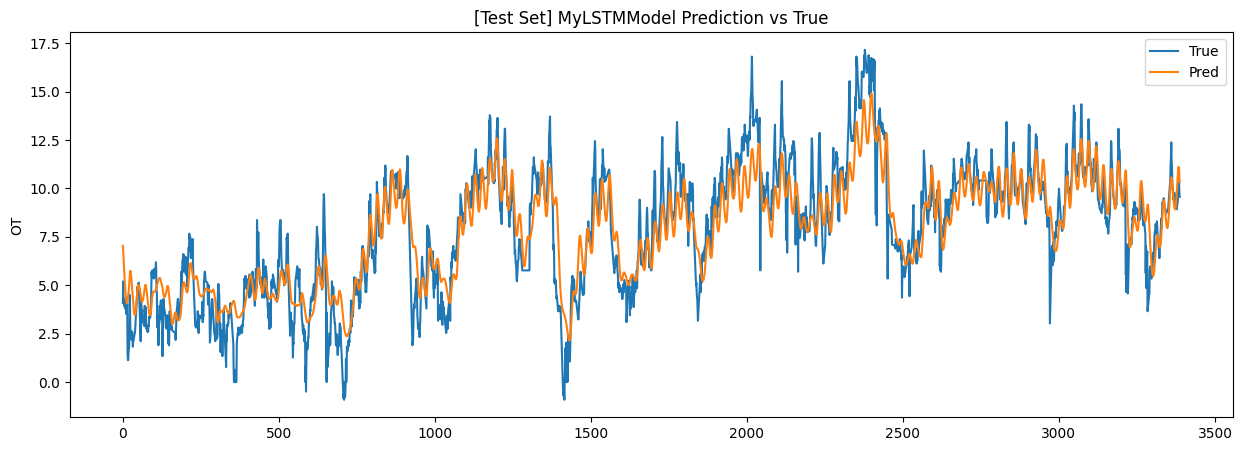

In [ ]:
# 4-2) 실제값과 예측값 시각화하여 결과 비교
# 원변수 시각화
pred = np.array(result["pred_inv"]) # [N,pred_len,1]
true = np.array(result["true_inv"]) # [N,pred_len,1]

N, pred_len, _ = pred.shape
total_len = N + pred_len - 1 # 총 길이

# 초기화
agg_pred = np.zeros(total_len)
agg_true = np.zeros(total_len)
count = np.zeros(total_len)

for i in range(N):
    agg_pred[i:i+pred_len] += pred[i,:,0]
    agg_true[i:i+pred_len] += true[i,:,0]
    count[i:i+pred_len] += 1

# 평균
agg_pred /= count
agg_true /= count

plt.figure(figsize=(15,5))
plt.plot(agg_true, label="True")
plt.plot(agg_pred, label="Pred")
plt.title(f"[Test Set] {cfg.MODEL.modelname} Prediction vs True")
plt.ylabel("OT")
plt.legend()
plt.show()
############################################################

**[한계점 및 개선 방향]**
<br>
본 모델은 기본 LSTM 구조로 동작하여 시계열의 단기 패턴은 잘 학습했지만, 몇 가지 한계가 존재한다.

**1. 예측 방식의 한계**
*   본 모델은 다중 시점 예측을 한 번에 출력하는 구조이다. 이 방식은 horizon이 길어질수록 정확도가 떨어지는 단점이 있다.

*   개선 방향: Recursive prediction 방식이나, seq2seq 구조를 활용할 수 있을 것이다.

**2. Attention Mechanism 부재**
*   LSTM은 순차적 의존성을 학습하는 데 강점이 있으나, 긴 시퀀스에서 중요한 시점에 집중하는 능력이 부족하다.
*   개선 방향: LSTM에 Attention을 추가하거나 Transformer 기반 모델을 활용하면, 장기 의존성 및 중요한 구간에 더 효과적으로 집중할 수 있을 것이다.
